## Imports

In [2]:
# Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats



## Feature Engineering

We applied feature engineering where additional relevant features are created from existing variables to enrich the dataset.
- we split the ‘datetime’ column into ‘date’ and ‘time’.
- we extracted the hour of the day from the new time feature and day of the week, the year, the day, and month from the new date feature.

This enables further visualizaitons and analysis.

## Preprocessing and Transformation

Machine learning algorithms are based on mathematical models and equations that involve numerical operations. As a result, any data provided to these algorithms needs to be in a numerical format.
Encoding variables is a crucial step in the preprocessing pipeline of machine learning. It allows algorithms to effectively work with a diverse range of data types, facilitating accurate predictions and valuable insights.  


When dealing with  mixed column types, it is often better/more efficient to apply different preprocessing steps to different sets of columns. In our case we use the `ColumnTransformer` class that allows us to specify different pipelines for different sets of features that handle the preprocessing.

We divided our columns/attributes into ordinal anf numerical attributes. 
- Categorical attributes were encoded using `OneHotEncoder`, handling unknown categories.
- Numerical attributes were encoded using `StandardScaler`.

The variable 'weather' has 4 categories which are not balenced. For example weather 4 (severe weather) only has one datapoint which we decided to drop because later we cannot split the datapoint equally into train and test sets. Additionally, it would not have been beneficial for our model, if we had decided do oversampling with systhetic datapoints. 

The data we have was gathered in two years, which means the variable "year" only has two options. We decided to drop the column and leave it out of our models because it should not influence our model, as it should not impeed user decisions and only data from 2 years are available. It would have also increased the risk of overfittig our models. 


In [3]:
# Preprocessing
# Load the data
yulu_data_set = pd.read_csv('yulu_bike_sharing_dataset.csv')

# Drop rows where the column "weather" equals 4
yulu_data_set = yulu_data_set[yulu_data_set['weather'] != 4]


# Split the 'datetime' column into 'date' and 'time' columns
yulu_data_set[['date', 'time']] = yulu_data_set['datetime'].str.split(' ', expand=True)
yulu_data_set = yulu_data_set.drop(columns=['datetime'])

# Extract features from 'date' column
yulu_data_set['year'] = pd.to_datetime(yulu_data_set['date']).dt.year
yulu_data_set['month'] = pd.to_datetime(yulu_data_set['date']).dt.month
yulu_data_set['day'] = pd.to_datetime(yulu_data_set['date']).dt.day
yulu_data_set['day_of_week'] = pd.to_datetime(yulu_data_set['date']).dt.dayofweek

# Extract hour from 'time' column
yulu_data_set['hour'] = pd.to_datetime(yulu_data_set['time'], format='%H:%M:%S').dt.hour

#Year should not influence our model, as it should not impeed user decisions and only data from 2 years are available. We don not want to have yulus growth in our model evaluation.
yulu_data_set = yulu_data_set.drop(columns= 'year')

# Drop original 'date' and 'time' columns as they are no longer needed
yulu_data_set = yulu_data_set.drop(columns=['date', 'time'])

# Specify the names of categorical and numerical columns
categorical_columns = ['season', 'holiday', 'workingday', 'weather', 'month', 'day', 'day_of_week'] 
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour'] 
target_column = 'count' 

# Creating a column transformer for handling both numerical and categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])


## Outlier Detection and Removal

An **outlier** is an observation that lies an abnormal distance from other values in a sample of values. Outliers will most likely impact the performance of the regression methods and that is why we will perform outlier detection before doing the regression.

### Z-score

We decided to use the method **Z-Score** for outlier detection.

A z-score (also standard score) gives you an idea of how far from the mean a data point is. It’s a measure of how many standard deviations below or above the population mean a raw score is.

### Threshold

The Z-Score method needs a parameter/value usually named **Threshold**.

The **Threshold** is a value that sets the boundary of which data points should be considered outliers. For example a threshold of 2 considers all datapoints with a **Z-Score** above 2 as outliers.

We decided to plot the number of outliers in relation to the threshold to see the destribution of our outliers according to the threshold.
We then decided to use a threshold of 3.5 which eliminates 62 outliers.

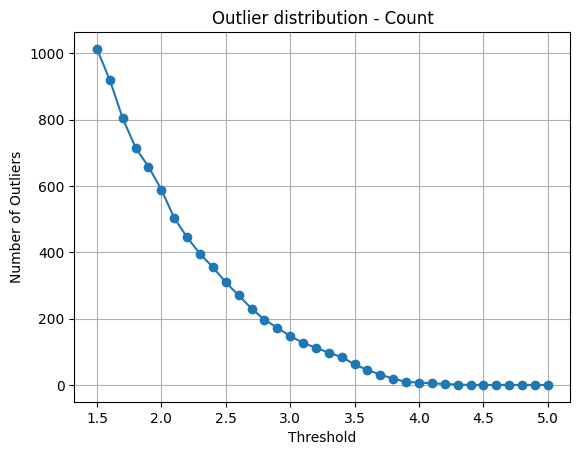

In [10]:
# Initialize lists to store results
# thresholds is a list of values from 1.5 to 5.0 with a step of 0.1
thresholds = np.arange(1.5, 5.1, 0.1)
num_outliers_list = []  # List to store the number of outliers for each threshold
threshold_list = []  # List to store the threshold values

# Loop through different thresholds
for i in thresholds:
    # Apply z-score outlier detection
    # z_scores is a list of z-scores for each data point in the 'salary_in_usd' column
    z_scores = np.abs(stats.zscore(yulu_data_set['count']))
    # outliers is a list of indices where the z-score is greater than the threshold
    outliers = np.where((z_scores > i) | (z_scores < -i))[0]

    # Store results
    # Number of outliers for the current threshold
    num_outliers = len(outliers)
    # Append the number of outliers to the list
    num_outliers_list.append(num_outliers)
    threshold_list.append(i)  # Append the current threshold to the list

# Plot knee point graph
plt.plot(threshold_list, num_outliers_list, marker='o', linestyle='-')
plt.title('Outlier distribution - Count')
plt.ylabel('Number of Outliers')
plt.xlabel('Threshold')
plt.grid(True)
plt.show()

In [5]:
# Outlier detection
# Set the threshold for outlier detection
threshold = 3.5

# Calculate the z-scores for each data point in the 'count' column
z_scores = stats.zscore(yulu_data_set['count'])

# Filter the data: only keep data points where the z-score is less than the threshold and greater than the negative threshold
data_without_outliers = yulu_data_set[(z_scores < threshold) & (z_scores > -threshold)]

# Print the number of outliers removed
print(f"Outliers removed: {len(yulu_data_set) - len(data_without_outliers)}")

Outliers removed: 62


## Train-test split

The split helps in detecting overfitting, a situation where the model performs exceptionally well on the training data but fails to generalize to new data. If the model performs significantly better on the training set compared to the test set, it might be overfitted.

As our variable is continous we had to sort and binn the target variable to ensure stratified sampling in the `train_test_split` method bellow.

As mentioned above, we used the `train_test_split` to split the data into train and test sets with the following options/parameters:
- **Stratified sampling** is used based on the binned 'count' variable (y_binned) to ensure that the training and testing sets have similar distributions all variables.
- **random_state=42** ensures reproducibility by fixing the random seed for the split.
- **test_size=0.2** ensures that 20% of the data is allocated for testing, leaving 80% for training. This split is a common practice to evaluate model performance on unseen data.


In [6]:
# Separate features and target
X = data_without_outliers
y = data_without_outliers['count']

# Convert target to a sorted NumPy array
sorted_y = np.sort(y)

# Determine the bin edges such that each bin has at least six entries
min_bin_size = 2
bin_edges = [sorted_y[0]]
for i in range(min_bin_size, len(sorted_y), min_bin_size):
    bin_edges.append(sorted_y[i-1])
bin_edges.append(sorted_y[-1])

# Remove duplicates and sort the bin edges
bin_edges = np.unique(bin_edges)

# Function to calculate bin counts consistently
def calculate_bin_counts(sorted_values, bin_edges):
    binned_values = pd.cut(sorted_values, bins=bin_edges, include_lowest=True)
    return binned_values.value_counts().sort_index()

# Ensure that each bin has at least min_bin_size entries by adjusting bins
bins_valid = False
while not bins_valid:
    bin_counts = calculate_bin_counts(sorted_y, bin_edges)
    if np.all(bin_counts >= min_bin_size):
        bins_valid = True
    else:
        # Merge bins with fewer than min_bin_size items
        invalid_bins = np.where(bin_counts < min_bin_size)[0]
        for idx in invalid_bins:
            if idx > 0:
                bin_edges = np.delete(bin_edges, idx)
                break

# Perform a final check and merge any bins with fewer than min_bin_size items
final_bin_counts = calculate_bin_counts(sorted_y, bin_edges)
while np.any(final_bin_counts < min_bin_size):
    invalid_bins = np.where(final_bin_counts < min_bin_size)[0]
    for idx in invalid_bins:
        if idx > 0:
            bin_edges = np.delete(bin_edges, idx)
            break
    final_bin_counts = calculate_bin_counts(sorted_y, bin_edges)

# Create bin labels
bin_labels = np.arange(1, len(bin_edges))  # Using indexes as labels

# Bin the values for stratification purposes
y_binned = pd.cut(y, bins=bin_edges, labels=bin_labels, include_lowest=True)

# Check that binning went as planned
print('Unique values in y:', y.nunique())
print('Unique values in y_binned:', y_binned.nunique())

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

# Overwrite categories with continious variable
y_test = X_test['count'].values
y_train = X_train['count'].values

# Dropping the real target from training
X_train = X_train.drop(columns='count')
X_test = X_test.drop(columns='count')

# Check if it worked out
# print(X_test)
# print(X_train)
# print(y_test)
# print(y_train)



Unique values in y: 772
Unique values in y_binned: 702


## Feature Selection

Feature selection plays a crucial role in enhancing the performance of machine learning models. It involves choosing a subset of relevant features or variables from the original set to improve model accuracy, reduce overfitting, increase interpretability and improve generalization.

Datasets contain features which may be redundant or irrelevant. By selecting only the most relevant features, we can reduce the dimensionality of the data, leading to simpler and more efficient models.

**Methods**

We have chosen `SelectKBest` with the `f_regression` scoring function for feature selection. 

**SelectKBest:** Is a technique that selects the top k features based on a statistical test applied independently to each feature. It helps to identify features that have the strongest relationship with the target variable.

The **f_regression** scoring function was chosen because it is suitable for regression problems. It measures the linear dependency between each feature and the target variable. Higher scores indicate stronger relationships, making it a valuable metric for feature importance in regression tasks.


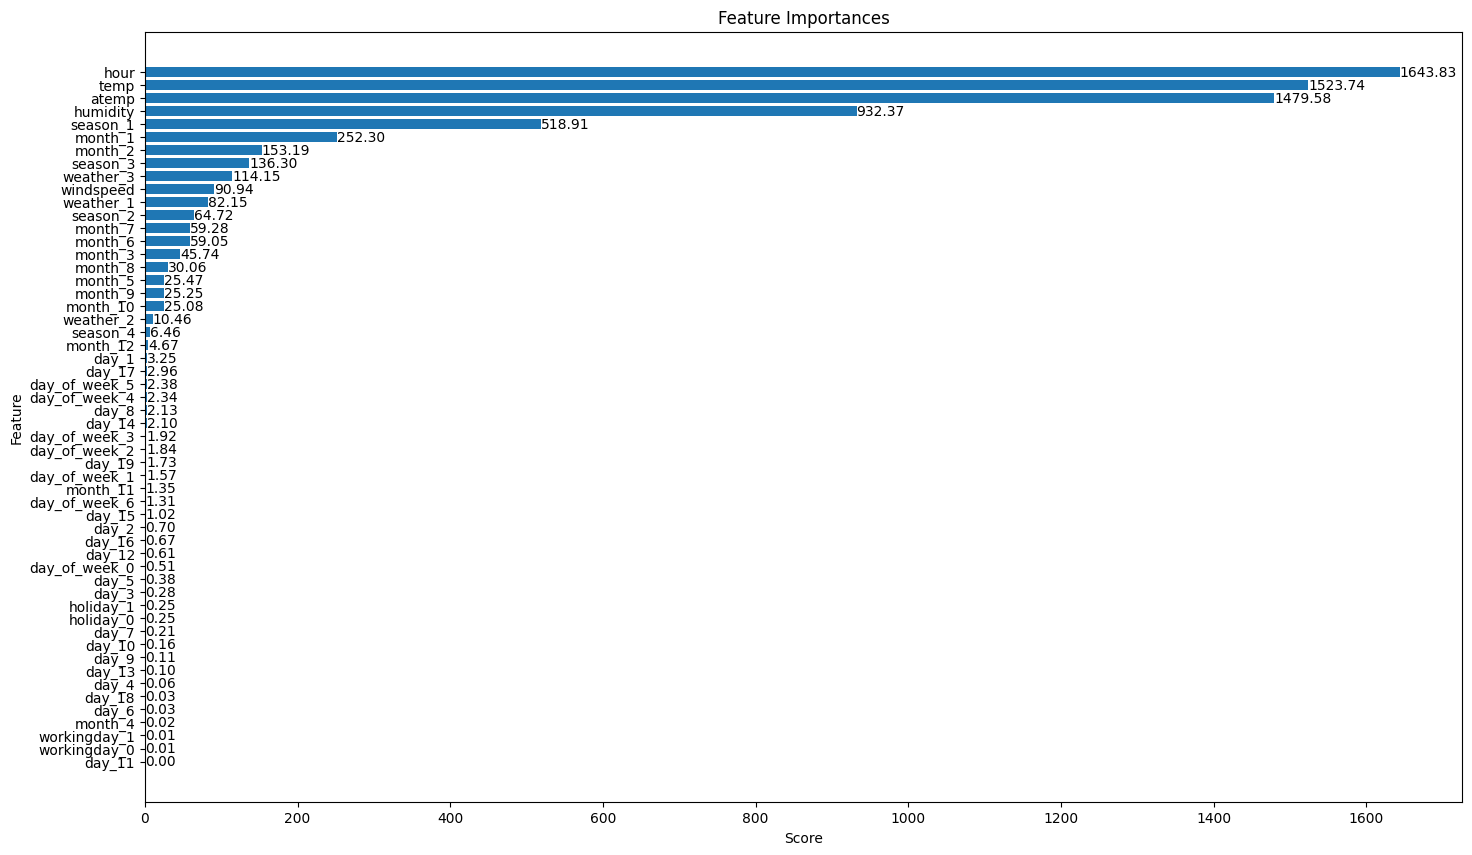

In [7]:
# Feature selection
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Apply SelectKBest with f_regression
k = 10  # Number of top features to select, adjust as needed
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)

# Get feature names
num_features = numerical_columns
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_features = list(num_features) + list(cat_features)

# Get the scores of the features
feature_scores = selector.scores_

# Create a DataFrame for visualization
feature_scores_df = pd.DataFrame({'Feature': all_features, 'Score': feature_scores})

# Sort the DataFrame by score
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Plot the feature importances with individual scores
plt.figure(figsize=(17, 10))
bars = plt.barh(feature_scores_df['Feature'], feature_scores_df['Score'])
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()

# Add the scores as text on the bars
for bar, score in zip(bars, feature_scores_df['Score']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

## Feature Selection by Column

Here plotted the feature imporatance grouped per column 

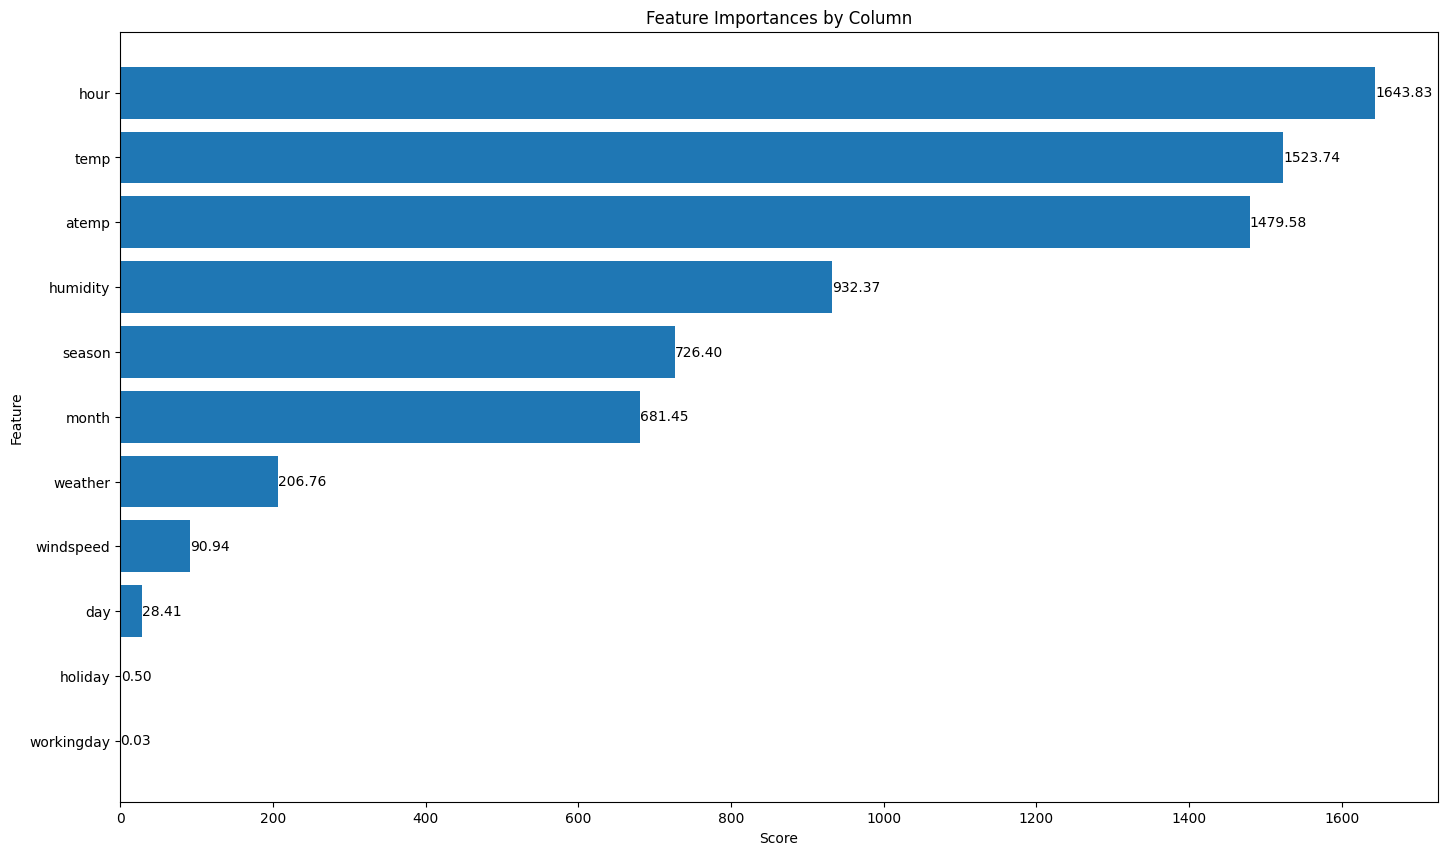

In [9]:
# Feature selection by column
# Aggregate the scores for the original categorical columns
categorical_scores = {}
for feature in cat_features:
    original_col = feature.split('_')[0]
    if original_col in categorical_scores:
        categorical_scores[original_col] += feature_scores[all_features.index(feature)]
    else:
        categorical_scores[original_col] = feature_scores[all_features.index(feature)]

# Combine numerical and aggregated categorical scores
final_feature_scores = {feature: score for feature, score in zip(num_features, feature_scores[:len(num_features)])}
final_feature_scores.update(categorical_scores)

# Convert to DataFrame for plotting
final_feature_scores_df = pd.DataFrame(list(final_feature_scores.items()), columns=['Feature', 'Score'])
final_feature_scores_df = final_feature_scores_df.sort_values(by='Score', ascending=False)

# Plot the feature importances by column with individual scores
plt.figure(figsize=(17, 10))
bars = plt.barh(final_feature_scores_df['Feature'], final_feature_scores_df['Score'])
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importances by Column')
plt.gca().invert_yaxis()

# Add the scores as text on the bars
for bar, score in zip(bars, final_feature_scores_df['Score']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

### Model Selection 

Model Selection is the process of selecting the best model from all the models in our pipeline on the basis of different criteria such as scores like MSE and RMSE.

We have create a  pipelines for different models. Each pipeline consists of preprocessing, feature selection, and a regressor.  
The feature selection and regressor are different for each model but each model has the same preprocessor.

We create pipelines to the following models:
-  knn regressor
-  linear regressor
-  random forest regressor

### Hyperparameter Optimization

We decided to include hyperparameter optimization in our models below.

Machine learning models often have hyperparameters, which are parameters that influence the learning of a model and is defined before the learning begins. Tuning these hyperparameters is essential for optimizing the model performance.

We created a grid for different parameter and model scenarios.  
Each grid consists of different combinations of hyperparameters for feature selection and the regressor.  
The grid will be used in `GridSearchCV` to find the best hyperparameters for each model. 

**GridSearchCV**

`GridSearchCV` is a hyperparameter tuning technique  used in machine learning. It systematically searches through a predefined grid of hyperparameter values and evaluates the model's performance for each combination using cross-validation. This exhaustive search helps identify the hyperparameter values that yield the best model performance.
- `GridSearchCV` automates the process by evaluating the model's performance across a grid of hyperparameter values, saving practitioners from manually testing different combinations.

- **Cross-validation** is a technique used to assess a model's performance by splitting the dataset into multiple subsets (folds) and training the model on different combinations of these folds. `GridSearchCV` employs cross-validation to provide a robust estimation of how well the model will generalize to new, unseen data.
Cross-validation helps mitigate overfitting by evaluating the model on multiple subsets of the data. This provides a more reliable estimate of the model's performance.
- It ensures that all data points are used for both training and validation, maximizing the utilization of available information.
- By averaging performance across multiple folds, cross-validation provides a more robust performance metric compared to a single train-test split.

In this context, **cv=5** specifies a 5-fold cross-validation, meaning the dataset is split into five subsets, and the model is trained and evaluated five times, each time using a different combination of four folds for training and one fold for validation. The average performance across these five evaluations is used to assess the model's overall performance.

## Linear Regression

In [27]:
# Define the range of k values
k_values = [ 10 , 15, 20, 25, 30, 'all'] 

# Hyperparameter tuning for Linear Regression including k
# Creating a pipeline with preprocessing and Linear Regression
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression)),
    ('regressor', LinearRegression())
])

# Define parameter grid for Linear Regression including k
param_grid_linear = {
    'selector__k': k_values
}

# Use GridSearchCV for hyperparameter tuning
grid_search_linear = GridSearchCV(linear_model, param_grid_linear, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_linear.fit(X_train, y_train)

# Best parameters and best score
print("Linear Regression Best Parameters:", grid_search_linear.best_params_)
print("Linear Regression Best Cross-validated MSE:", -grid_search_linear.best_score_)

# Fit the best model on training data
best_linear_model = grid_search_linear.best_estimator_
best_linear_model.fit(X_train, y_train)

# Predictions
y_pred_linear = best_linear_model.predict(X_test)

# Metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression Mean Squared Error (MSE):", mse_linear)
print("Linear Regression Mean Absolute Error (MAE):", mae_linear)
print("Linear Regression R-squared:", r2_linear)


Linear Regression Best Parameters: {'selector__k': 20}
Linear Regression Best Cross-validated MSE: 19968.688356004568
Linear Regression Mean Squared Error (MSE): 18253.511230727538
Linear Regression Mean Absolute Error (MAE): 102.2780532496552
Linear Regression R-squared: 0.377999657076989


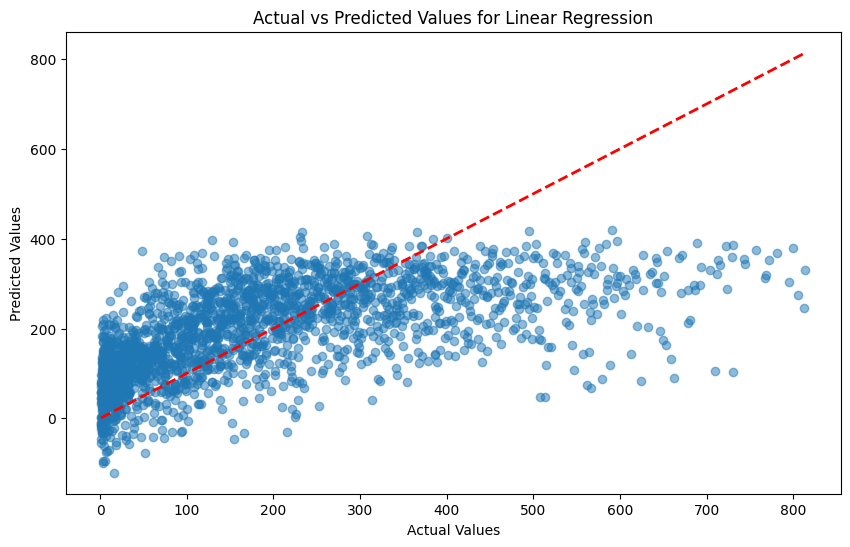

In [28]:
# Plot a graph to see actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Linear Regression')
plt.show()

## Random Forest Regressor

In [33]:
# Hyperparameter tuning for RandomForestRegressor

#How many features are used
k_values = [ 10 , 12 , 14] 

# Creating a pipeline with preprocessing and Random Forest regressor
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression)),
    ('regressor', RandomForestRegressor())
])

# Define parameter grid for RandomForest
param_grid = {
    'selector__k': k_values,
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [None, 10, 12, 15]
}


# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Random Forest Best Parameters:", grid_search.best_params_)
print("Random Forest Best Cross-validated MSE:", -grid_search.best_score_)

# Fit the best model on training data
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error (MSE):", mse_rf)
print("Random Forest Mean Absolute Error (MAE):", mae_rf)
print("Random Forest R-squared:", r2_rf)


Random Forest Best Parameters: {'regressor__max_depth': 12, 'regressor__n_estimators': 150, 'selector__k': 14}
Random Forest Best Cross-validated MSE: 9885.718699368337
Random Forest Mean Squared Error (MSE): 9005.506405426728
Random Forest Mean Absolute Error (MAE): 63.38548055899517
Random Forest R-squared: 0.6931314747301066


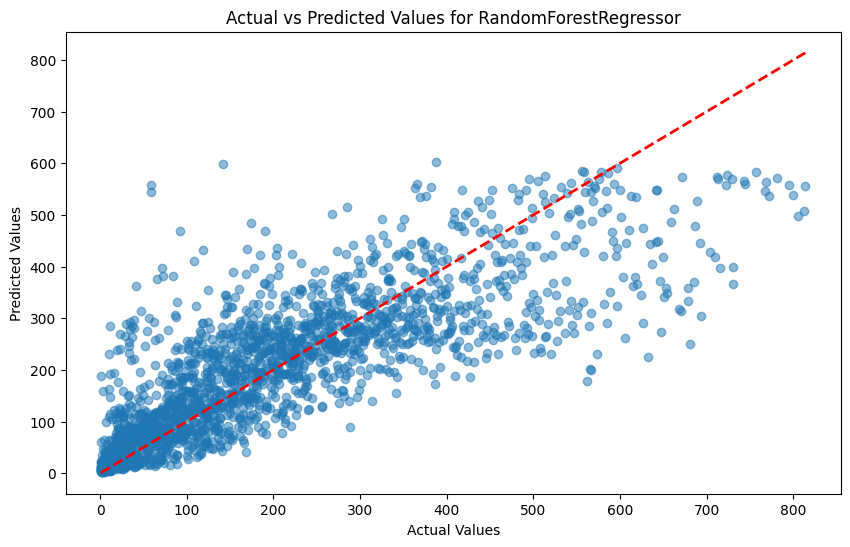

In [36]:
# Plot a graph to see actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for RandomForestRegressor')
plt.show()

## KNN Regressor

In [31]:
#How many features are used
k_values = [ 10 , 12, 25, 25, 30, 'all'] 

# Preprocessing, feature selection, and Model Training (KNeighborsRegressor)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('select_k_best', SelectKBest(score_func=f_regression)),
    ('regressor', KNeighborsRegressor())
])

# Define the grid of hyperparameters to search
parameters = {
    'select_k_best__k': k_values,
    'regressor__n_neighbors' : [3, 5, 8, 10]
}

# Instantiating GridSearchCV
grid_search_KNN = GridSearchCV(pipeline, parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


# Fit the model on the training data
grid_search_KNN.fit(X_train, y_train)


# Predict
y_pred_KNN = grid_search_KNN.predict(X_test)

# Best parameters used
print(" KNN-Regression Best Parameters:", grid_search_KNN.best_params_)

# Print performance metrics
print("KNN Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_KNN))
print("KNN Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_KNN))
print("KNN R-squared:", r2_score(y_test, y_pred_KNN))

 KNN-Regression Best Parameters: {'regressor__n_neighbors': 8, 'select_k_best__k': 10}
KNN Mean Squared Error (MSE): 11646.560544168591
KNN Mean Absolute Error (MAE): 75.62015011547344
KNN R-squared: 0.6031358262649318


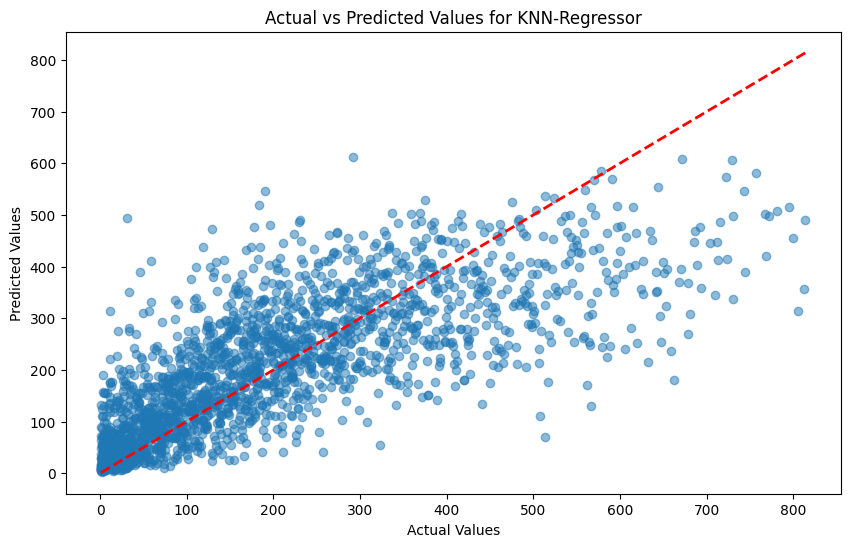

In [35]:
# Plot a graph to see actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_KNN, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for KNN-Regressor')
plt.show()